Advanced sequencing
================

In this tutorial we will demonstrate advanced sequencer based operations, where we focus on waveform parametrization (see section [Sequencer](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/sequencer.html)). We will demonstrate this by creating a sequence that will show various sequencer features, 
including complex looping constructs, dynamic gain control, hardware-based modulation and marker output control.

The sequence itself will use four waveform envelopes with a duration of 1μs each; a gaussian, a sine, a sawtooth and a block. We will have several nested loops
in the sequence. The first loop will increase the wait period between the start of the iteration and playback of the waveform envelope and also increase the gain of
the waveform envelope on every iteration. At the end of this loop a second loop will do the inverse operations. A third loop will loop over the first and
second loops to iterate over the four waveform envelopes. And finally a fourth loop will function as an infinite loop over the third loop.
At the same time, the sequence will also control marker output 1 and create a trigger point at the start of each iteration of the first and second loops as well an
"enable" during playback. Finally, each waveform envelope will be modulated at 10MHz.

The result of this sequence, when observed on an oscilloscope, will be iterating waveform envelopes that will be sliding over the modulation frequency with varying gain,
encapsulated by an "enable" on the marker output. We highly recommend that you take a look at it, to get an impression of what is possible with the sequencers.

We can perform this tutorial with either a Pulsar QCM/QRM or a Cluster QCM/QRM . We use the term 'QxM' encompassing both QCM and QRM modules.

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages.

In [1]:
# Import ipython widgets
import json
import math
import os

import ipywidgets as widgets
import matplotlib.pyplot
import numpy

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive

from qblox_instruments import Cluster, PlugAndPlay, Pulsar

### Scan For Devices

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/pnp.html) for more info).

In [2]:
# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()
    device_keys = list(device_list.keys())

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[(device_list[key]["description"]["name"]) for key in device_list.keys()],
    description="Select Device",
)
print(
    "The following widget displays all the existing modules that are connected to your PC which includes the Pulsar modules as well as a Cluster. Select the device you want to run the notebook on."
)
display(connect)

The following widget displays all the existing modules that are connected to your PC which includes the Pulsar modules as well as a Cluster. Select the device you want to run the notebook on.


Dropdown(description='Select Device', options=('cluster-mm',), value='cluster-mm')

#### Pulsar QxM <a id='pulsar_setup'></a>
Run this cells after selecting the your Pulsar module. Skip to the [Cluster QxM section](#cluster_setup) below if you have selected a Cluster module.

In [ ]:
Pulsar.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# Connect to device and reset
qxm = Pulsar(f"{device_name}", ip_address)
qxm.reset()
print(f"{device_name} connected at {ip_address}")
print(qxm.get_system_state())

Skip to the next section [(Generate Waveform)](#gen_wf) if you are not using a cluster. 

#### Cluster QxM <a id='cluster_setup'></a>
First we connect to the Cluster using its IP address. Go to the [Pulsar QxM section](#pulsar_setup) if you are using a Pulsar.


In [3]:
# close all previous connections to the cluster
Cluster.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# connect to the cluster
cluster = Cluster(device_name, ip_address)
cluster.reset()
print(f"{device_name} connected at {ip_address}")

cluster-mm connected at 192.168.1.0


We then find all available cluster modules to connect to them individually.

In [4]:
# Find all QRM/QCM modules
available_slots = {}
for module in cluster.modules:
    # if module is currently present in stack
    if cluster._get_modules_present(module.slot_idx):
        # check if QxM is RF or baseband
        if module.is_rf_type:
            available_slots[f"module{module.slot_idx}"] = ["QCM-RF", "QRM-RF"][
                module.is_qrm_type
            ]
        else:
            available_slots[f"module{module.slot_idx}"] = ["QCM", "QRM"][
                module.is_qrm_type
            ]

# List of all QxM modules present
connect_qxm = widgets.Dropdown(options=[key for key in available_slots.keys()])

print(available_slots)
# display widget with cluster modules
print()
print("Select the QxM module from the available modules in your Cluster:")
display(connect_qxm)

{'module2': 'QCM', 'module4': 'QRM'}

Select the QxM module from the available modules in your Cluster:


Dropdown(options=('module2', 'module4'), value='module2')

Finally, we connect to the selected Cluster module. 

In [5]:
# Connect to the cluster QxM module
module = connect_qxm.value
qxm = getattr(cluster, module)
print(f"{available_slots[connect_qxm.value]} connected")
print(cluster.get_system_state())

QCM connected
Status: OKAY, Flags: NONE, Slot flags: NONE


Generate waveforms <a id='gen_wf'></a>
------------------

Next, we need to create the gaussian, sine, sawtooth and block waveform envelopes for the sequence.

In [6]:
# Waveform parameters
waveform_length = 1000  # nanoseconds

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
    "gaussian": {
        "data": scipy.signal.gaussian(
            waveform_length, std=0.12 * waveform_length
        ).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [
            math.sin((2 * math.pi / waveform_length) * i)
            for i in range(0, waveform_length)
        ],
        "index": 1,
    },
    "sawtooth": {
        "data": [(1.0 / (waveform_length)) * i for i in range(0, waveform_length)],
        "index": 2,
    },
    "block": {"data": [1.0 for i in range(0, waveform_length)], "index": 3},
}

Let's plot the waveforms to see what we have created.

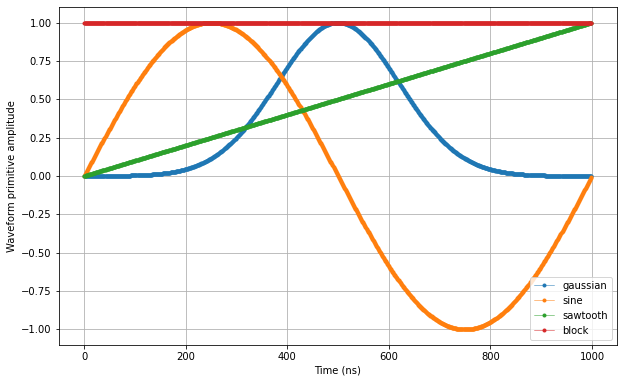

In [7]:
time = numpy.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

matplotlib.pyplot.draw()
matplotlib.pyplot.show()

Create Q1ASM program
--------------------

Now that we have the waveforms for the sequence, we need a Q1ASM program that sequences the waveforms as previously described.

In [8]:
# Sequence program.
seq_prog = """
                  wait_sync    4                    #Wait for synchronization
                  reset_ph                          #Reset absolute phase
                  upd_param    4                    #Update all parameters and wait 4ns
start:            move         4,R0                 #Init number of waveforms
                  move         0,R1                 #Init waveform index

mult_wave_loop:   move         166,R2               #Init number of single wave loops (increasing wait)
                  move         166,R3               #Init number of single wave loops (decreasing wait)
                  move         24,R4                #Init number of dynamic wait time (total of 4us)
                  move         3976,R5              #Init number of dynamic wait time remainder
                  move         32768,R6             #Init gain (Maximum gain)

sngl_wave_loop_0: move         800,R7               #Init number of long wait loops (total of 40ms)
                  set_mrk      15                   #Set marker to 0xF
                  upd_param    4                    #Update all parameters and wait 4ns
                  set_mrk      0                    #Set marker to 0
                  upd_param    96                   #Update all parameters and wait 96ns

                  wait         R4                   #Dynamic wait
                  add          R4,24,R4             #Increase wait

                  set_mrk      1                    #Set marker to 1
                  play         R1,R1,996            #Play waveform and wait 996ns
                  set_mrk      0                    #Set marker to 0
                  upd_param    4                    #Update all parameters and wait for 4ns

                  wait         R5                   #Compensate previous dynamic wait
                  sub          R5,24,R5             #Decrease wait

                  sub          R6,98,R6             #Decrease gain
                  nop
                  set_awg_gain R6,R6                #Set gain

long_wait_loop_0: wait         50000                #Wait 50 us
                  loop         R7,@long_wait_loop_0 #Wait total of 40ms
                  loop         R2,@sngl_wave_loop_0 #Repeat single wave loop

sngl_wave_loop_1: move         800,R7               #Init number of long wait loops (total of 40ms)
                  set_mrk      15                   #Set marker to 0xF
                  upd_param    8                    #Update all parameters and wait 8ns
                  set_mrk      0                    #Set marker to 0
                  upd_param    92                   #Update all parameters and wait 92ns

                  wait         R4                   #Dynamic wait
                  sub          R4,24,R4             #Decrease wait

                  set_mrk      1                    #Set marker to 1
                  play         R1,R1,996            #Play waveform and wait 996ns
                  set_mrk      0                    #Set marker to 0
                  upd_param    4                    #Update all parameters and wait 4ns

                  wait         R5                   #Compensate previous dynamic wait
                  add          R5,24,R5             #Increase wait

                  sub          R6,98,R6             #Decrease gain
                  nop
                  set_awg_gain R6,R6                #Set gain

long_wait_loop_1: wait         50000                #Wait for 50 us
                  loop         R7,@long_wait_loop_1 #Wait total of 40ms
                  loop         R3,@sngl_wave_loop_1 #Repeat single wave loop

                  add          R1,1,R1              #Adjust waveform index
                  loop         R0,@mult_wave_loop   #Repeat with next waveform envelope
                  jmp          @start               #Repeat entire sequence
"""

Upload sequence
---------------

Now that we have the waveforms and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [9]:
# Add sequence to single dictionary and write to JSON file.
seqeunce = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": {},
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(seqeunce, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 and 1, which will drive outputs $\text{O}^{[1-2]}$ and $\text{O}^{[3-4]}$ respectively.

In [10]:
# Upload sequence.
qxm.sequencer0.sequence("sequence.json")
qxm.sequencer1.sequence("sequence.json")

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers in the instrument to use the `wait_sync` instruction
at the start of the Q1ASM program to synchronize and to enable the hardware-based modulation at 10MHz.

In [11]:
# Configure the sequencers to synchronize and enable modulation at 10MHz.
qxm.sequencer0.sync_en(True)
qxm.sequencer0.mod_en_awg(True)
qxm.sequencer0.nco_freq(10e6)
qxm.sequencer1.sync_en(True)
qxm.sequencer1.mod_en_awg(True)
qxm.sequencer1.nco_freq(10e6)

# Map sequencers to specific outputs (but first disable all sequencer connections).
for sequencer in qxm.sequencers:
    for out in range(0, 4):
        if hasattr(sequencer, "channel_map_path{}_out{}_en".format(out % 2, out)):
            sequencer.set("channel_map_path{}_out{}_en".format(out % 2, out), False)

# If it is a QRM, we only map sequencer 0 to the outputs.
qxm.sequencer0.channel_map_path0_out0_en(True)
qxm.sequencer0.channel_map_path1_out1_en(True)
if qxm.is_qcm_type:
    qxm.sequencer1.channel_map_path0_out2_en(True)
    qxm.sequencer1.channel_map_path1_out3_en(True)

Now let's start the sequence. If you want to observe the sequence, this is the time to connect an oscilloscope to marker output 1 and one or more
of the four outputs. Configure the oscilloscope to trigger on marker output 1.

In [12]:
# Arm and start sequencers.
qxm.arm_sequencer(0)
qxm.arm_sequencer(1)
qxm.start_sequencer()

# Print status of sequencers.
print(qxm.get_sequencer_state(0))
print(qxm.get_sequencer_state(1))

Status:
Status: RUNNING, Flags: NONE
Status: RUNNING, Flags: NONE


Before we continue, have you looked at the oscilloscope? Pretty nifty right? This is just an example. Imagine what else you can do with the power of
the sequencers to control and/or speed up your experiments.

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [ ]:
# Stop both sequencers.
qxm.stop_sequencer()

# Print status of both sequencers (should now say it is stopped).
print(qxm.get_sequencer_state(0))
print(qxm.get_sequencer_state(1))
print()

# Uncomment the following to print an overview of the instrument parameters.
# print("Snapshot:")
# qxm.print_readable_snapshot(update=True)

# Close the instrument connection.
Pulsar.close_all()
Cluster.close_all()